In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, RFE

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/IS4303/notebooks/new_cleaned

Mounted at /content/drive
/content/drive/MyDrive/IS4303/notebooks/new_cleaned


### Helpers (run before the rest)

In [2]:
# Function to be used later
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score


def plot_preds(preds, probas, truth):
  auc_score = roc_auc_score(truth, probas)
  prec = precision_score(truth, preds)
  rec = recall_score(truth, preds)
  f1 = f1_score(truth, preds)
  print(f"AUC: {auc_score:.2f}\n")
  print(f'Precision: {prec:.2f}')
  print(f'Recall: {rec:.2f}')
  print(f"F1: {f1:.2f}\n")

  fpr, tpr, thresholds = roc_curve(truth, probas)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()

In [3]:
df = pd.read_csv('3cleaned_cyclical.csv')
df.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,assigned_room_type_L,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,arrival_date_month_cos,arrival_date_week_number_cos
0,0,7,0,1,1,0.0,0,0,0,0,...,0,0,0,1,0,1,0,0,-0.866025,-0.998244
1,0,13,0,1,1,0.0,0,0,0,0,...,0,0,0,1,0,1,0,0,-0.866025,-0.998244
2,0,14,0,2,2,0.0,0,0,0,0,...,0,0,0,1,0,1,0,0,-0.866025,-0.998244
3,0,0,0,2,2,0.0,0,0,0,0,...,0,0,0,1,0,1,0,0,-0.866025,-0.998244
4,0,9,0,2,2,0.0,0,0,0,0,...,0,0,0,1,0,1,0,0,-0.866025,-0.998244


## Finding optimal number of dimentions for PCA

Trying out a modest 0.95 explained variance threshold, with a proportion of variance explained criterion.

In [ ]:
def optimal_pca(data, explained_variance_threshold=0.95, zero_threshold=1e-6):
  scaler = StandardScaler()
  standardized_data = scaler.fit_transform(data)
  pca = PCA(random_state=123)
  pca.fit(standardized_data)
  cumulative_var = np.cumsum(pca.explained_variance_ratio_)

  n_var = np.argmax(cumulative_var >= explained_variance_threshold) + 1
  n_all = np.argmin(np.abs(pca.explained_variance_ratio_) > zero_threshold) + 1 # number of dims right exp. variance threshold reaches 0

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='orange', label='Explained variance ratio')
  ax1.axvline(n_var, color='r', linestyle='--', label=f'Dimensions at 0.95 threshold: {n_var}')
  ax1.axvline(n_all, color='b', linestyle='--', label=f'Dimensions when plot flattens: {n_all}')
  ax1.set_title('Explained Variance Ratio')
  ax1.set_xlabel('Number of dimensions')
  ax1.set_ylabel('Explained variance ratio')
  ax1.legend()
  ax1.grid()

  ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, color='purple', label='Cumulative explained variance')
  ax2.axvline(n_var, color='r', linestyle='--', label=f'Dimensions at 0.95 threshold: {n_var}')
  ax2.axvline(n_all, color='b', linestyle='--', label=f'Dimensions when plot flattens: {n_all}')
  ax2.set_title('Cumulative Explained Variance')
  ax2.set_xlabel('Number of dimensions')
  ax2.set_ylabel('Cumulative explained variance')
  ax2.legend()
  ax2.grid()

  plt.show()
  
  print(f'Optimal number of dimensions using explained variance criterion: {n_var}')

  return n_var, n_all

In [4]:
def get_new_split():
  y = df['is_canceled']
  X = df.drop('is_canceled', axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
  return X_train, X_test, y_train, y_test

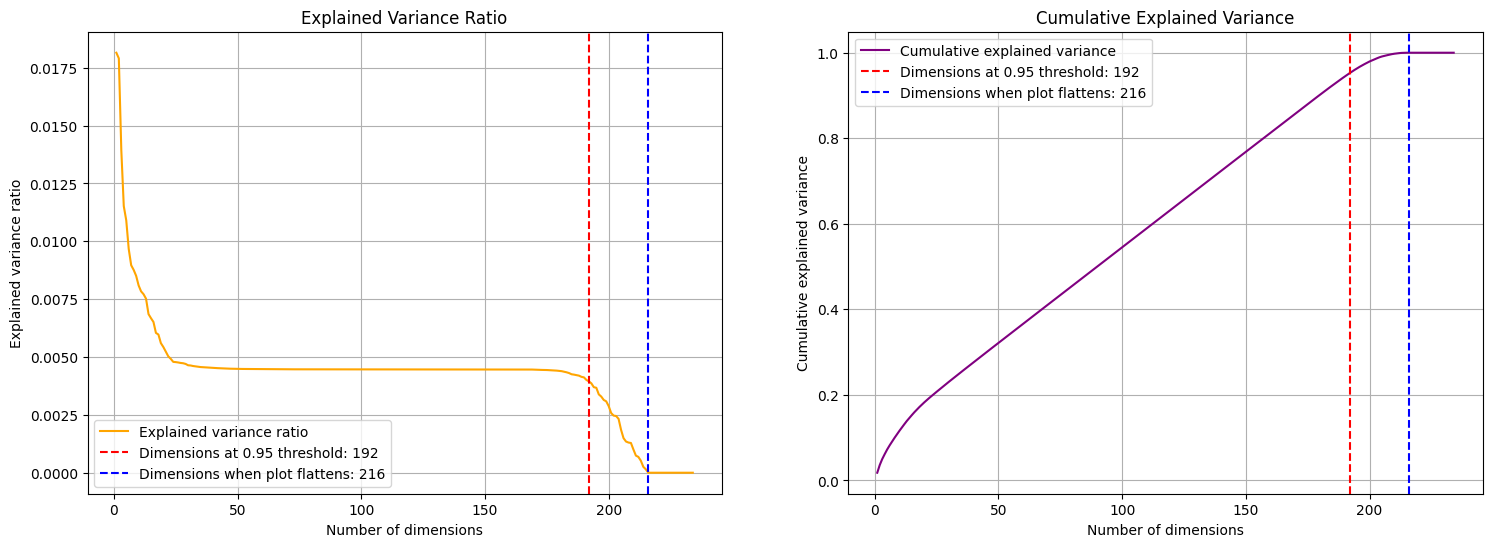

Optimal number of dimensions using explained variance criterion: 192


In [ ]:
X_train, _, _, _ = get_new_split()
n_opt, n_all = optimal_pca(X_train)

Using 0.95 threshold dimensions
AUC: 0.81

Precision: 0.67
Recall: 0.46
F1: 0.55



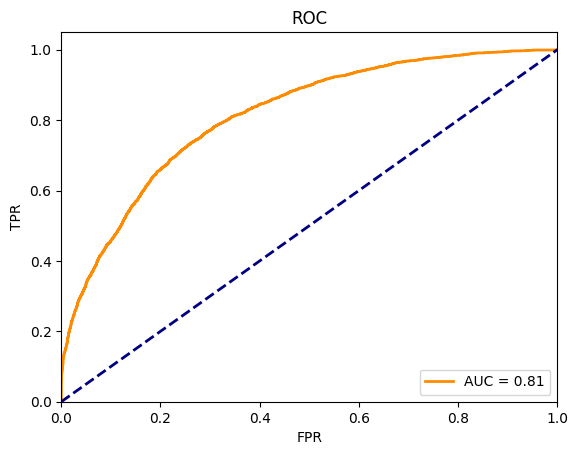

Using dimensions when the curve flattens
AUC: 0.82

Precision: 0.67
Recall: 0.48
F1: 0.56



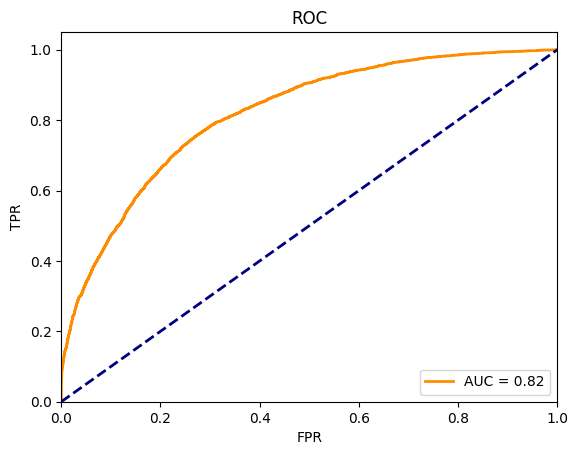

In [ ]:
# Trying out baseline model with 192 dimensions, compared with using number of dimensions where the plot flattens.

def test_logreg_with_pca(n_feat, title):
  pca_pipeline = Pipeline([ # just before RFE, since we need to map
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_feat, random_state=123))
  ])

  X_train, X_test, y_train, y_test = get_new_split()
  pca_pipeline.fit(X_train)
  X_train = pca_pipeline.transform(X_train)
  X_test = pca_pipeline.transform(X_test)

  from sklearn.linear_model import LogisticRegression
  clf =  LogisticRegression(max_iter=1000).fit(X_train, y_train) # iter high due to convergence error
  print(title)
  y_pred = clf.predict(X_test)
  y_pred_proba = clf.predict_proba(X_test)[:,1]
  plot_preds(y_pred, y_pred_proba, y_test)

test_logreg_with_pca(n_opt, 'Using 0.95 threshold dimensions')
test_logreg_with_pca(n_all, 'Using dimensions when the curve flattens')

## Feature selection with RFE
- Since dimensions after PCA is still high.
- Using 192 dimensions from PCA, due to the negligible difference 216, given a 28 dimension difference.

In [ ]:
pca_pipeline = Pipeline([ # just before RFE, since we need to map
  ('scaler', StandardScaler()),
  ('pca', PCA(n_components=n_opt, random_state=123))
])

X_train, X_test, y_train, y_test = get_new_split()
pca_pipeline.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=192, random_state=123))])

Finding optimal number of features
- Finds the minimum number of features that is at most 0.02 away from the best F1 score.
- This is because training a model using all features after PCA (192) yields a really good score - and RFECV might return a high number.



In [ ]:
def optimal_feature_selection(X, y, performance_tolerance=0.02):
  estimator = LogisticRegression(max_iter=1000)
  cv = StratifiedKFold(n_splits=3)
  rfecv = RFECV(estimator=estimator, step=1, cv=cv, n_jobs=-1, scoring='f1')
  rfecv.fit(X, y)

  best_score = np.max(rfecv.cv_results_['mean_test_score'])
  scores_within_tolerance = np.where(rfecv.cv_results_['mean_test_score'] >= (best_score - performance_tolerance))
  n_tol = np.min(scores_within_tolerance) + 1 # +1 for zero-based indexing

  print(f"Optimal number of features (best score): {rfecv.n_features_}")
  print(f"Optimal number of features (within tolerance): {n_tol}")

  return n_tol

In [ ]:
X_transformed = pca_pipeline.transform(X_train)
rfe_opt = optimal_feature_selection(X_transformed, y_train)

Optimal number of features (best score): 171
Optimal number of features (within tolerance): 126


In [ ]:
pca_rfe_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('pca', PCA(n_components=n_opt, random_state=123)),
  ('rfe', RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=rfe_opt))
])

X_train, X_test, y_train, y_test = get_new_split()
pca_rfe_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=192, random_state=123)),
                ('rfe',
                 RFE(estimator=LogisticRegression(max_iter=1000),
                     n_features_to_select=126))])

In [ ]:
with open('PCA_RFE_pipeline.pkl', 'wb') as file:
  pickle.dump(pca_rfe_pipeline, file)

In [ ]:
X_train_transformed = pca_rfe_pipeline.transform(X_train)
X_test_transformed = pca_rfe_pipeline.transform(X_test)

AUC: 0.80

Precision: 0.67
Recall: 0.44
F1: 0.53



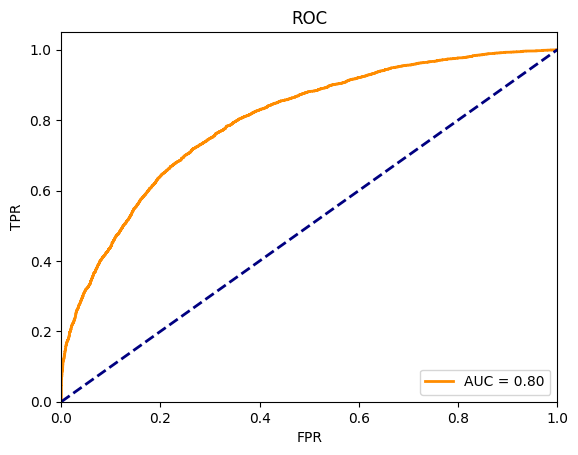

In [ ]:
clf =  LogisticRegression(max_iter=1000).fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)
y_pred_proba = clf.predict_proba(X_test_transformed)[:,1]
plot_preds(y_pred, y_pred_proba, y_test)

In [ ]:
print(type(X_train_transformed))
X_train_transformed.shape

<class 'numpy.ndarray'>


(51474, 126)

In [ ]:
X_train_transformed

array([[ 1.85739047,  0.93560516,  0.30672492, ..., -0.2172636 ,
         0.50119642, -0.01627073],
       [-1.09993988,  1.01065362, -0.07377265, ...,  0.33625278,
         0.29086676,  0.50500244],
       [ 2.83120684, -1.60854314, -0.98037911, ...,  0.14035923,
         0.49127831,  0.32070748],
       ...,
       [-0.6777526 ,  0.49147972, -0.31221951, ...,  0.24335539,
         0.27734598,  0.41108253],
       [-0.34653233, -2.16756241, -1.89488012, ...,  0.18143268,
         0.05682591,  0.59657555],
       [ 3.17400167,  0.2037745 ,  0.24184249, ...,  1.52877603,
         1.23496624,  1.05455871]])

In [ ]:
X_train_df = pd.DataFrame(X_train_transformed)
X_test_df = pd.DataFrame(X_test_transformed)

In [ ]:
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,1.857390,0.935605,0.306725,-0.341325,-0.705822,0.230374,-0.293881,0.137795,-0.348196,0.335365,...,0.339529,-0.754362,0.037655,1.154427,0.991007,1.347402,0.238041,-0.217264,0.501196,-0.016271
1,-1.099940,1.010654,-0.073773,-1.165517,1.755400,-0.788734,-1.151073,0.056051,0.494490,-0.254673,...,0.030201,0.061846,0.093652,0.084886,0.011084,0.070041,0.038199,0.336253,0.290867,0.505002
2,2.831207,-1.608543,-0.980379,-0.345282,-1.061499,0.346373,0.172566,0.281709,-0.174018,-0.720004,...,-0.105376,-0.524714,0.093866,0.127520,-0.234882,-0.057871,1.109911,0.140359,0.491278,0.320707
3,-1.578140,-2.723531,-1.062074,-0.007207,0.477565,0.077956,-0.038696,-1.361463,1.504887,-0.550795,...,-0.005365,0.132756,0.187048,-0.147892,0.230808,0.006233,-0.429521,-0.205547,-0.274699,0.467357
4,0.411165,-0.846027,0.238843,1.559518,-1.145391,1.228239,-0.134868,0.073261,-0.150559,0.340541,...,0.241353,-0.610966,0.078780,1.099824,0.750756,1.254893,0.482117,-0.224027,0.585873,-0.862597


In [ ]:
X_train_df.to_csv('4X_train.csv', index=False)
X_test_df.to_csv('4X_test.csv', index=False)
y_train.to_csv('4y_train.csv', index=False)
y_test.to_csv('4y_test.csv', index=False)

In [ ]:
pd.read_csv('4X_train.csv').head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,1.857390,0.935605,0.306725,-0.341325,-0.705822,0.230374,-0.293881,0.137795,-0.348196,0.335365,...,0.339529,-0.754362,0.037655,1.154427,0.991007,1.347402,0.238041,-0.217264,0.501196,-0.016271
1,-1.099940,1.010654,-0.073773,-1.165517,1.755400,-0.788734,-1.151073,0.056051,0.494490,-0.254673,...,0.030201,0.061846,0.093652,0.084886,0.011084,0.070041,0.038199,0.336253,0.290867,0.505002
2,2.831207,-1.608543,-0.980379,-0.345282,-1.061499,0.346373,0.172566,0.281709,-0.174018,-0.720004,...,-0.105376,-0.524714,0.093866,0.127520,-0.234882,-0.057871,1.109911,0.140359,0.491278,0.320707
3,-1.578140,-2.723531,-1.062074,-0.007207,0.477565,0.077956,-0.038696,-1.361463,1.504887,-0.550795,...,-0.005365,0.132756,0.187048,-0.147892,0.230808,0.006233,-0.429521,-0.205547,-0.274699,0.467357
4,0.411165,-0.846027,0.238843,1.559518,-1.145391,1.228239,-0.134868,0.073261,-0.150559,0.340541,...,0.241353,-0.610966,0.078780,1.099824,0.750756,1.254893,0.482117,-0.224027,0.585873,-0.862597
